# Library Recommender

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
repo_url = "https://raw.githubusercontent.com/baertsch/MGT-502-ML-Project/main/"

# Load datasets
interactions_train_df = pd.read_csv(repo_url + "kaggle_data/interactions_train.csv")
interactions_train_df.rename(columns={"u": "user_id"}, inplace=True)
#items_df = pd.read_csv(repo_url + "kaggle_data/items.csv")
items_df = pd.read_csv(repo_url + "kaggle_data/items_df.csv")
sample_submission_df = pd.read_csv(repo_url + "kaggle_data/sample_submission.csv")

#Display
display(interactions_train_df.head())
display(items_df.head())
display(sample_submission_df.head())



,user_id,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,['UDC Consortium (The Hague)'],9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,"['Aneta Slowik', 'Hervé Breton', 'Gaston Pineau']",2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [3]:
n_users = interactions_train_df['user_id'].nunique()
n_items = items_df['i'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of books in the library: {items_df['i'].nunique()}")

Number of users: 7838
Number of books in the library: 15291


It looks like there are __7838__ users and __15291__ books in the library.

## Split the data

In [4]:
# Sort the interactions_train_df by 'user_id' and 'timestamp'
interactions_train_df.sort_values(by=['user_id', 't'], inplace=True)
interactions_train_df['pct_rank'] = interactions_train_df.groupby('user_id')['t'].rank(pct=True, method='dense')
interactions_train_df.reset_index(drop=True, inplace=True)
interactions_train_df.head(10)

,user_id,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [5]:
train_data = interactions_train_df[interactions_train_df['pct_rank'] <= 0.8]
test_data = interactions_train_df[interactions_train_df['pct_rank'] > 0.8]
print("Training set size:", train_data.shape[0])
print("Test set size:", test_data.shape[0])

Training set size: 66577
Test set size: 20470


In [6]:
print(train_data[['user_id','i']].duplicated().sum())
print(test_data[['user_id','i']].duplicated().sum())

16055
2044


It seems that the some users have interacted with some items more than once.

## First model: Item-to-Item

We are going to build first a model which treats doesn't account for the frequency a user has interacted with an item.

### Create User-Item Matrices

In [7]:
def create_data_matrix1(data, n_users, n_items):
    """
    This function creates a data matrix with binary values for the interactions, 1 is interaction and 0 is no interaction.
    The data matrix is of shape (n_users, n_items). 
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data['user_id'].values, data['i'].values] = 1
    return data_matrix

In [8]:
train_data_matrix = create_data_matrix1(train_data, n_users, n_items)
test_data_matrix = create_data_matrix1(test_data, n_users, n_items)

# Display the matrices
print("Training data matrix")
print(train_data_matrix)
print("Number of interactions: ", np.sum(train_data_matrix))
print("Testing data matrix")
print(test_data_matrix)
print("Number of interactions: ", np.sum(test_data_matrix))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  50522.0
Testing data matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  18426.0


### Visualization of the matrices for a small portion of the data

In [9]:
def plot_interaction_heatmap1(data_matrix, n_users=50,n_items=50, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='YlGnBu', cbar=True,cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

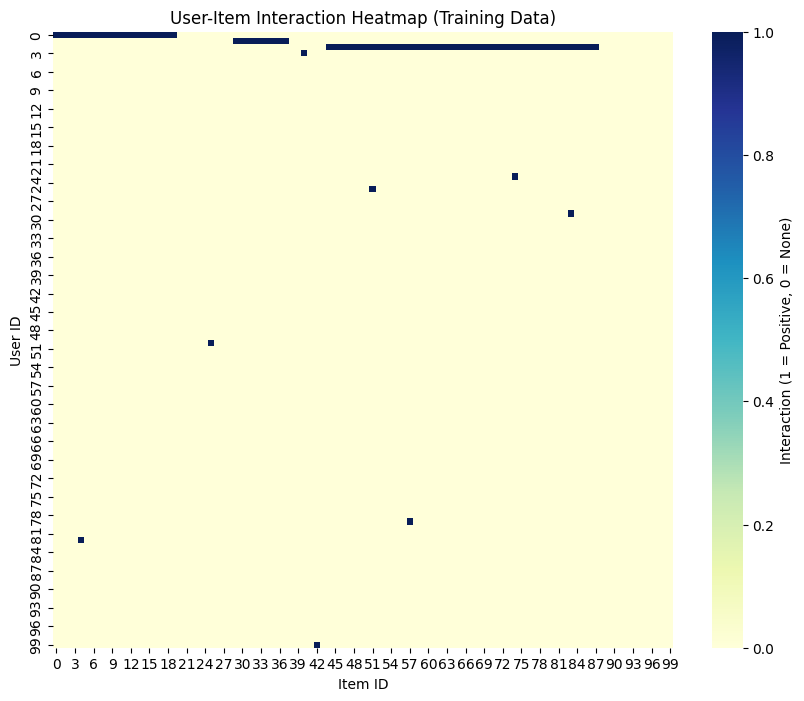

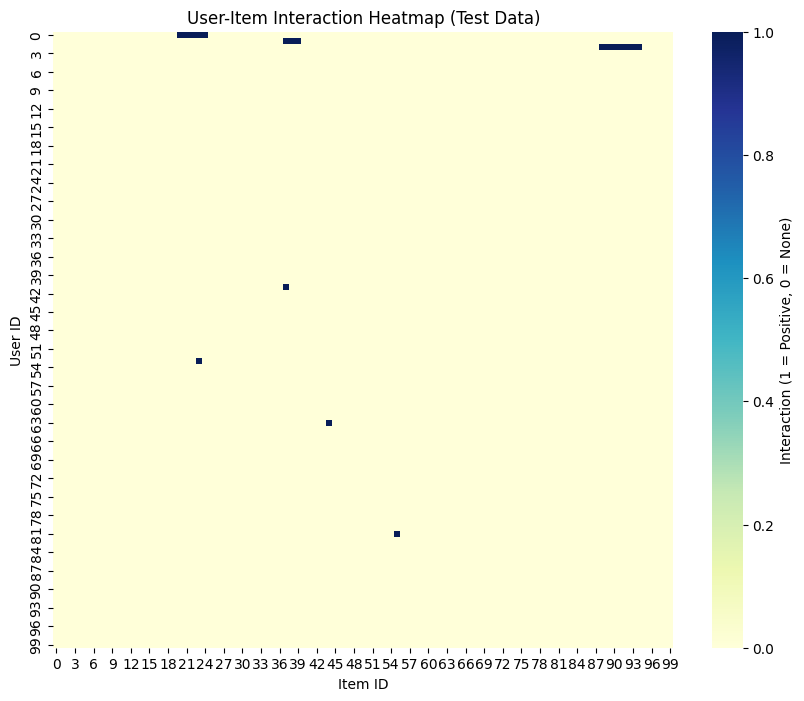

In [10]:
plot_interaction_heatmap1(train_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Training Data)")
plot_interaction_heatmap1(test_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Test Data)")

### Item Similarity

In [11]:
item_similarity = cosine_similarity(train_data_matrix.T)
print(item_similarity)
print("Item similarity shape:", item_similarity.shape)

[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
Item similarity shape: (15291, 15291)


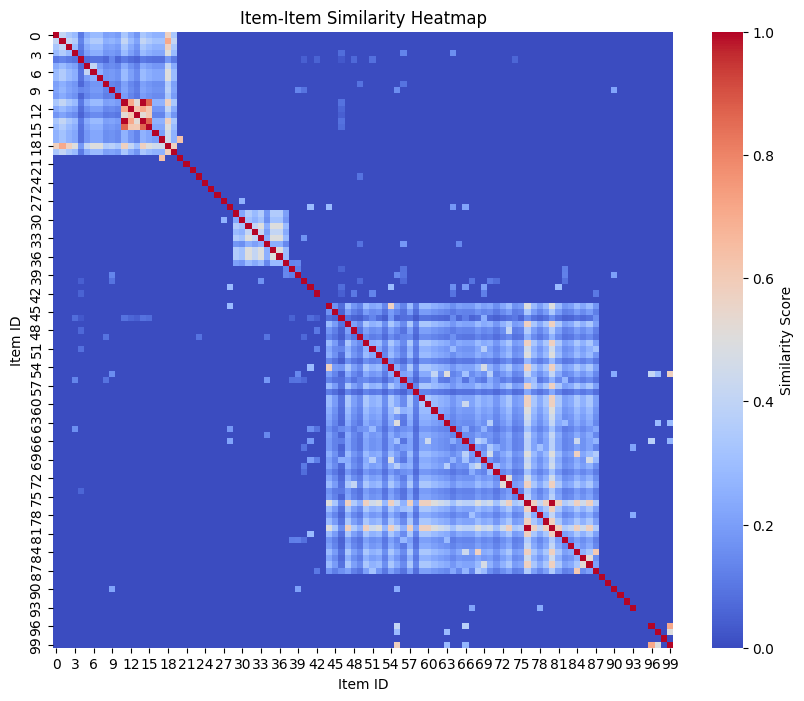

In [12]:
# Let's visualize the item similarity matrix
def plot_similarity_heatmap(matrix, n_items=50, title="Item Similarity Heatmap",x_label='X ID',y_label='y ID'):
    """
    This function plots a heatmap of the item similarity matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:n_items, :n_items], cmap='coolwarm', cbar=True,cbar_kws={'label': 'Similarity Score'})
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
plot_similarity_heatmap(item_similarity, n_items=100, title="Item-Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

Let's look at the clusters of high similarity 

In [13]:
items_df[(items_df['i']>=11) & (items_df['i']<=15)]

,Title,Author,ISBN Valid,Publisher,Subjects,i
11,Rendre les élèves acteurs de leurs apprentissa...,"Béal, Yves",9782206013725; 220601372X,Delagrave,apprentissage (psychologie)--enfant; apprentis...,11
12,L'apprentissage par projets au secondaire : gu...,"Larmer, John",9782765033202; 276503320X,Chenelière éducation,apprentissage (psychologie)--enseignement seco...,12
13,Pour une pédagogie du projet /,"Bordalo, Isabelle",9782011709219; 2011709210,Hachette éducation,Enseignement--Méthode des projets,13
14,Une classe qui coopère : pourquoi ? comment ? /,"Staquet, Christian",9782850084324; 2850084328,Chronique sociale,apprentissage (psychologie)--classe (enseignem...,14
15,Penser le projet : concepts et outils d'une pé...,"Tilman, Francis",2850085510; 9782850085512,Chronique sociale,pédagogie de la maîtrise,15


In [14]:
items_df[(items_df['i']>=0) & (items_df['i']<=19)][['Title','Subjects']]

,Title,Subjects
0,Classification décimale universelle : édition ...,Classification décimale universelle; Indexatio...
1,Les interactions dans l'enseignement des langu...,didactique--langue étrangère - enseignement; d...
2,Histoire de vie et recherche biographique : pe...,Histoires de vie en sociologie; Sciences socia...
3,Ce livre devrait me permettre de résoudre le c...,Moyen-Orient; Bandes dessinées autobiographiqu...
4,Les années glorieuses : roman /,France--1945-1975; Roman historique; Roman fra...
5,100 idées pour mieux gérer les troubles de l'a...,Trouble déficitaire de l'attention avec ou san...
6,La boîte à outils des formateurs : 71 outils...,Formateurs (éducation des adultes)--Formation...
7,L'autorité éducative dans la classe : douze si...,autorité--relation maître-élève; autorité--ens...
8,Un autre regard sur le climat /,Climat--Détérioration; Bandes dessinées
9,Le mirage de la croissance verte /,Développement économique--Aspect environnement...


In [15]:
# Find item pairs with similarity between 0.8 and 1
similar_items = []
threshold_min = 0.8
threshold_max = 1.0

for i in range(item_similarity.shape[0]):
    for j in range(i + 1, item_similarity.shape[1]):  # Avoid duplicate pairs and self-similarity
        if threshold_min <= item_similarity[i, j] <= threshold_max:
            similar_items.append((i, j, item_similarity[i, j]))

# Display the results
print("Item pairs with similarity between 0.8 and 1:")
for item1, item2, similarity in similar_items:
    print(f"Item {item1} and Item {item2} have similarity: {similarity}")

Item pairs with similarity between 0.8 and 1:
Item 11 and Item 15 have similarity: 0.8660254037844388
Item 14 and Item 15 have similarity: 0.8660254037844388
Item 21 and Item 13479 have similarity: 1.0
Item 76 and Item 80 have similarity: 1.0
Item 93 and Item 14554 have similarity: 0.816496580927726
Item 96 and Item 10806 have similarity: 1.0
Item 103 and Item 13174 have similarity: 1.0
Item 103 and Item 14597 have similarity: 1.0
Item 103 and Item 15068 have similarity: 1.0
Item 103 and Item 15249 have similarity: 1.0
Item 107 and Item 8074 have similarity: 1.0
Item 151 and Item 11561 have similarity: 0.8660254037844388
Item 153 and Item 156 have similarity: 0.9258200997725515
Item 185 and Item 8284 have similarity: 0.816496580927726
Item 189 and Item 3531 have similarity: 0.8944271909999159
Item 206 and Item 9605 have similarity: 1.0
Item 224 and Item 13036 have similarity: 1.0
Item 273 and Item 14059 have similarity: 1.0
Item 273 and Item 14060 have similarity: 1.0
Item 273 and Item

In [16]:
display(items_df[(items_df['i']==76)])
display(items_df[(items_df['i']==80)]) 

,Title,Author,ISBN Valid,Publisher,Subjects,i
76,Silver spoon = La cuillère d'argent /,"Arakawa, Hiromu, 1973-",9782351428344; 235142834X; 9782351428351; 2351...,Kurokawa,Bandes dessinées; Mangas,76


,Title,Author,ISBN Valid,Publisher,Subjects,i
80,Erased /,"Sanbe, Kei",9782355926990; 2355926999; 9782355927140; 2355...,Ki-oon,Mangas; Bandes dessinées,80


### Prediction using User Similarity

In [17]:
def item_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on item similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The item-item similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T

In [18]:
item_based_predictions = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix using Item-to-Item Similarity")
print(item_based_predictions)
print("Predicted Interaction Matrix shape:", item_based_predictions.shape)

Predicted Interaction Matrix using Item-to-Item Similarity
[[0.47610083 0.86088344 0.70208194 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


Let's visualize again.

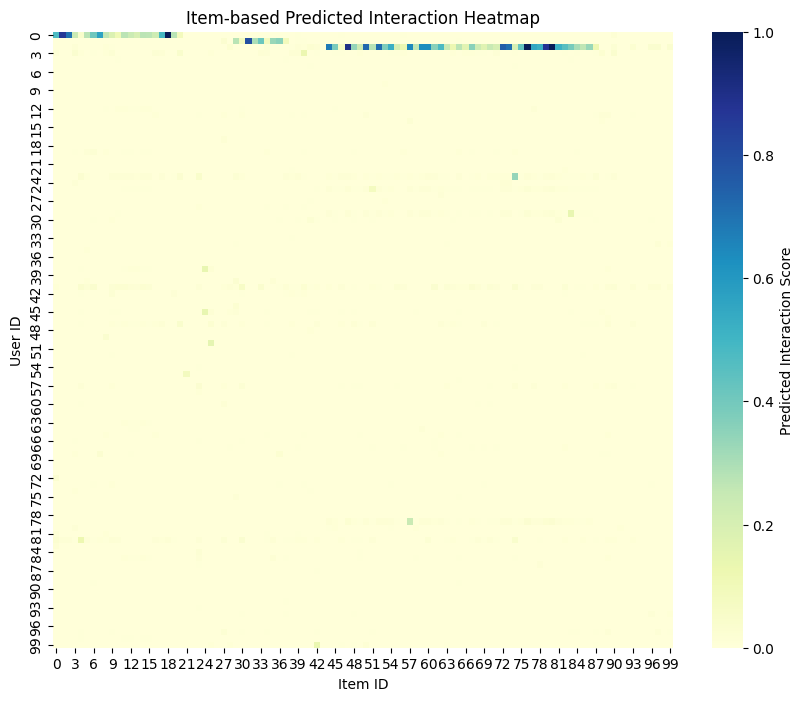

In [19]:
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=100,num_items=100):
    matrix_subset = prediction_matrix[:num_users, :num_items]
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='YlGnBu', cbar=True,cbar_kws={'label': 'Predicted Interaction Score'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

plot_interaction_prediction_heatmap(item_based_predictions, title="Item-based Predicted Interaction Heatmap")

## Model: User-to-User Collaborative Filtering with Implicit Feedback

### User Similarity Matrix

In [20]:
user_similarity = cosine_similarity(train_data_matrix)
print(user_similarity)
print("User similarity shape:", user_similarity.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
User similarity shape: (7838, 7838)


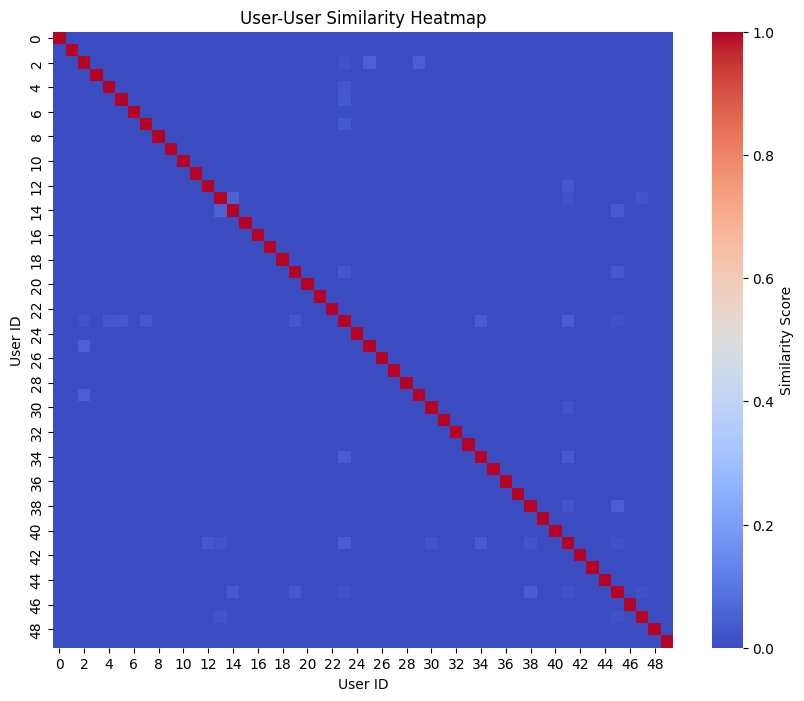

In [21]:
plot_similarity_heatmap(user_similarity, n_items=50, title="User-User Similarity Heatmap",x_label='User ID',y_label='User ID')

### Prediction using User Similarity

\begin{equation}
{p}_{u}(i) = \frac{\sum\limits_{u' \in U} \text{sim}(u, u') \cdot {R}_{u'}(i)}{\sum\limits_{u' \in U} \text{sim}(u, u')}
\end{equation}


Explanation:
*   $P_u(i)$ is the likelihood of user $u$ interacting with item $i$. This is the value we want to compute.
*   $\text{sim}(u, u')$ is the cosine similarity between users $u$ and $u'$.
*   $R_u'(i)$ is one if user $u'$ has already interacted with item $i$. Otherwise it is zero.
*   $U$ is the set of all users in the dataset.

This formula calculates the likelihood of interaction between user $ u $ and item $ i $ based on interactions of similar users with that item. The weighted sum of interactions from similar users is normalized by the sum of the similarities.

In [22]:
def user_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on user similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The user-user similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred


In [23]:
user_based_predictions = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix using User-to-User Similarity")
print(user_based_predictions)
print("Predicted Interaction Matrix shape:", user_based_predictions.shape)

Predicted Interaction Matrix using User-to-User Similarity
[[0.13214859 0.13301098 0.14092961 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


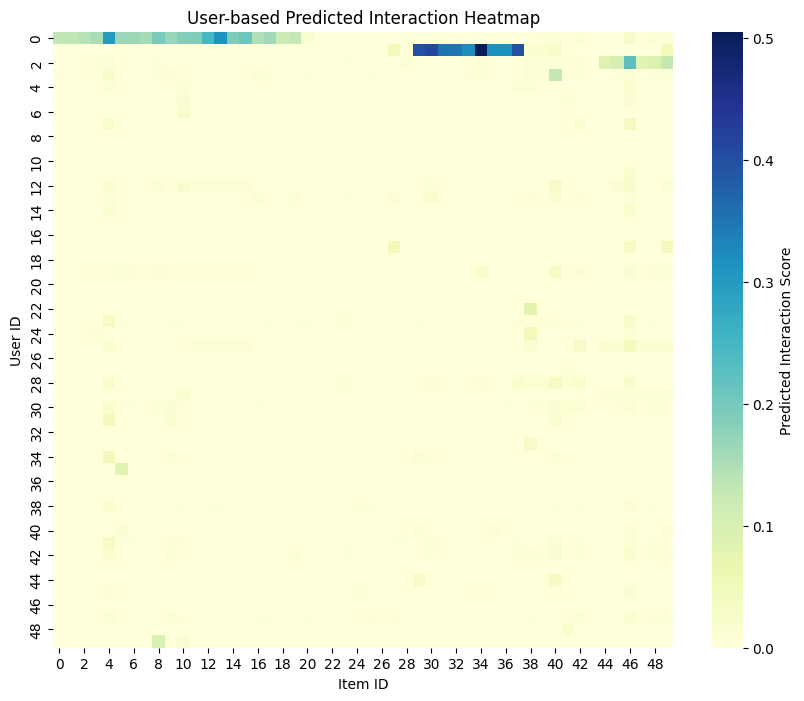

In [24]:
plot_interaction_prediction_heatmap(user_based_predictions, title="User-based Predicted Interaction Heatmap", num_users=50,num_items=50)

## Evaluation of the two recommender models

In [25]:
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k,map_at_k = 0, 0, 0

    for user in range(num_users):
        # Step 1: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]  # Complete this line to retrieve top-K item indices for the user
        
        # Step 2: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.sum([ground_truth[user,i] for i in top_k_items]) 
        
        # Step 3: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()  

        # Update Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

        avg_precision_at_k = 0
        for i in range(k):
            if ground_truth[user, top_k_items[i]] == 1:
                avg_precision_at_k += np.sum(ground_truth[user, top_k_items[:i+1]]) / (i + 1)
        map_at_k += avg_precision_at_k / k 

    # Step 4: Calculate the average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users
    map_at_k /= num_users
    
    return precision_at_k, recall_at_k, map_at_k

In [26]:
precision_item_k, recall_item_k, map_item_k= precision_recall_at_k(item_based_predictions, test_data_matrix, k=10)
precision_user_k, recall_user_k, map_user_k = precision_recall_at_k(user_based_predictions, test_data_matrix, k=10)


print('Item-based CF Precision@K for k=10:', precision_item_k)
print('Item-based CF Recall@K for k=10:', recall_item_k)
print('Item-based CF MAP@K for k=10:', map_item_k)
print('User-based CF Precision@K for k=10:', precision_user_k)
print('User-based CF Recall@K for k=10:', recall_user_k)
print('User-based CF MAP@K for k=10:', map_user_k)

Item-based CF Precision@K for k=10: 0.05348303138556009
Item-based CF Recall@K for k=10: 0.265111674068191
Item-based CF MAP@K for k=10: 0.015955904689000062
User-based CF Precision@K for k=10: 0.05422301607553199
User-based CF Recall@K for k=10: 0.2921432184678953
User-based CF MAP@K for k=10: 0.015472717367971576


## Recommendations dataframe using the best model -> User-based model

In [27]:
def create_recommendations_csv(predictions_matrix,name='recommendations.csv'):
    user_based_recommendations = []
    for user_id in range(predictions_matrix.shape[0]):
        # Indices of the top 10 items for each user (based on predicted interactions)
        top_10_items = np.argsort(predictions_matrix[user_id])[-10:][::-1]  # Sorting them in descending order
        
        top_10_items_str = " ".join(map(str, top_10_items))
        
        # Append the user_id and the recommendations as a string
        user_based_recommendations.append([user_id, top_10_items_str])

    recommendations_df = pd.DataFrame(user_based_recommendations, columns=['user_id', 'recommendation'])
    recommendations_df.to_csv(name, index=False)
    print("Recommendations CSV created successfully.")
    return recommendations_df

In [28]:
recommendations_df = create_recommendations_csv(user_based_predictions, name='user_based_recommendations.csv')
recommendations_df.head()

Recommendations CSV created successfully.


,user_id,recommendation
0,0,13 4 12 15 8 14 11 10 9 5
1,1,34 30 29 37 31 32 33 36 35 1573
2,2,46 58 53 49 56 64 82 75 45 67
3,3,149 138 40 155 128 142 143 156 139 133
4,4,202 198 191 203 193 201 197 196 199 195


In [29]:
recommendations_df.to_csv('user_recommendations.csv', index=False)

## Inclusion of frequency

This one accounts the number of times the user has interacted with the item. So in the formula:

\begin{equation}
{p}_{u}(i) =  \frac{\sum\limits_{i' \in I} \text{sim}(i, i') \cdot {R}_{u}(i')}{\sum\limits_{i' \in I} \text{sim}(i, i')}
\end{equation}

$R_u(i')$ is the number of times user u interacted with item i'

In [30]:
def create_data_matrix2(data, n_users, n_items):
    """
    This function creates a data matrix with frequency values for the interactions. 
    The matrix is of shape (n_users, n_items) where each value represents the frequency of interaction.
    """
    # Initialize a matrix of zeros, where rows represent users and columns represent items
    data_matrix = np.zeros((n_users, n_items))
    
    # Add the frequency of interactions between users and items
    for _, row in data.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['i'])
        data_matrix[user_id, item_id] += 1  # Increment the count for each interaction
    
    return data_matrix

In [31]:
train_data_matrix2 = create_data_matrix2(train_data, n_users, n_items)
# Display the matrices
print("Training data matrix")
print(train_data_matrix2)
print("Number of interactions: ", np.sum(train_data_matrix2))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  66577.0


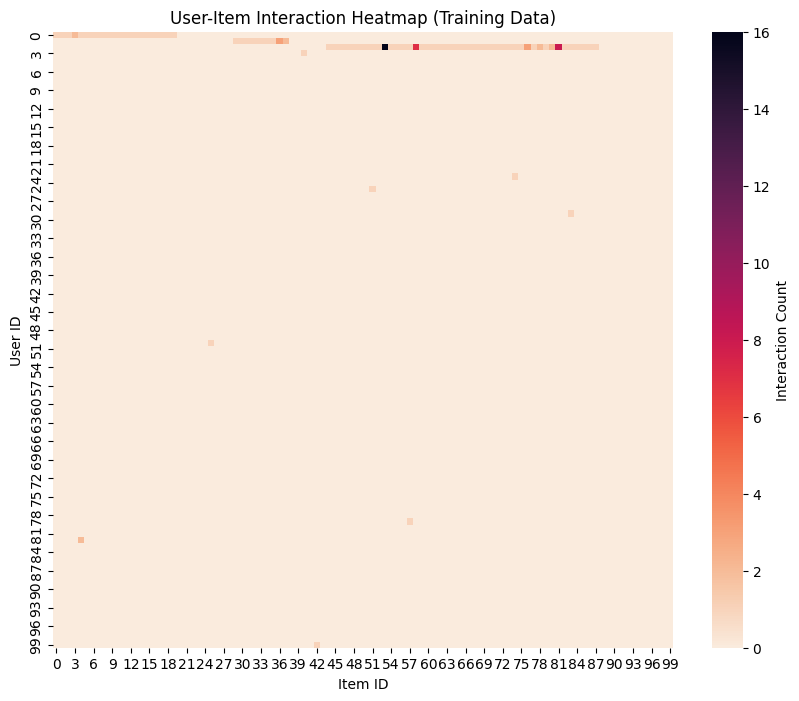

In [33]:
def plot_interaction_heatmap2(data_matrix, n_users=100,n_items=100, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='rocket_r', cbar=True,cbar_kws={'label': 'Interaction Count'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

plot_interaction_heatmap2(train_data_matrix2, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Training Data)")

### Let's try an user-to-user collaborative filtering with implicit feedback with these matrices

In [34]:
user_similarity2 = cosine_similarity(train_data_matrix2)
print(user_similarity2)
print("User similarity shape:", user_similarity2.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
User similarity shape: (7838, 7838)


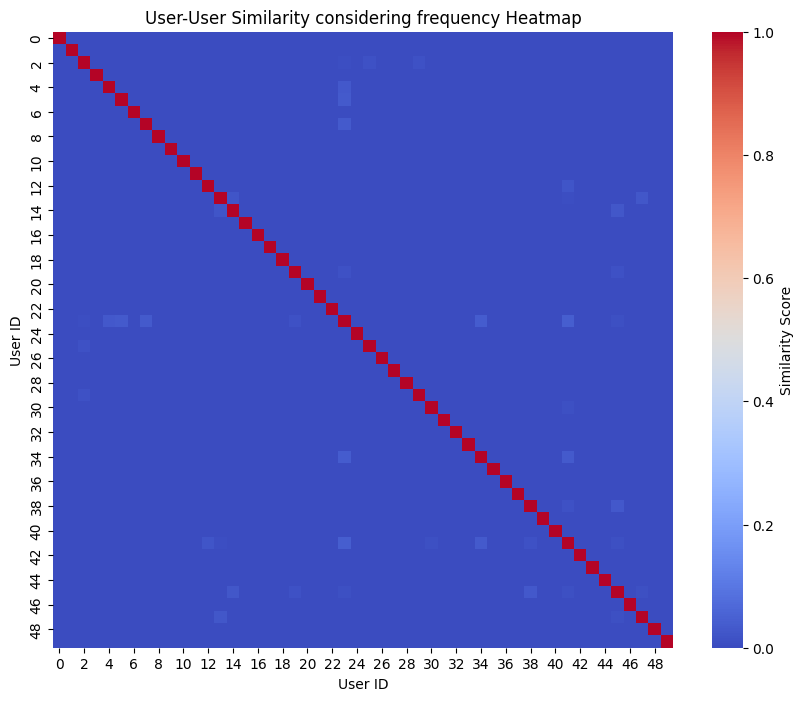

In [35]:
plot_similarity_heatmap(user_similarity2, n_items=50, title="User-User Similarity considering frequency Heatmap",x_label='User ID',y_label='User ID')

In [36]:
user_based_predictions2 = user_based_predict(train_data_matrix2, user_similarity2)
print("Predicted Interaction Matrix using User-to-User Similarity considering frequency")
print(user_based_predictions2)
print("Predicted Interaction Matrix shape:", user_based_predictions2.shape)

Predicted Interaction Matrix using User-to-User Similarity considering frequency
[[0.14853884 0.15968423 0.14621199 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


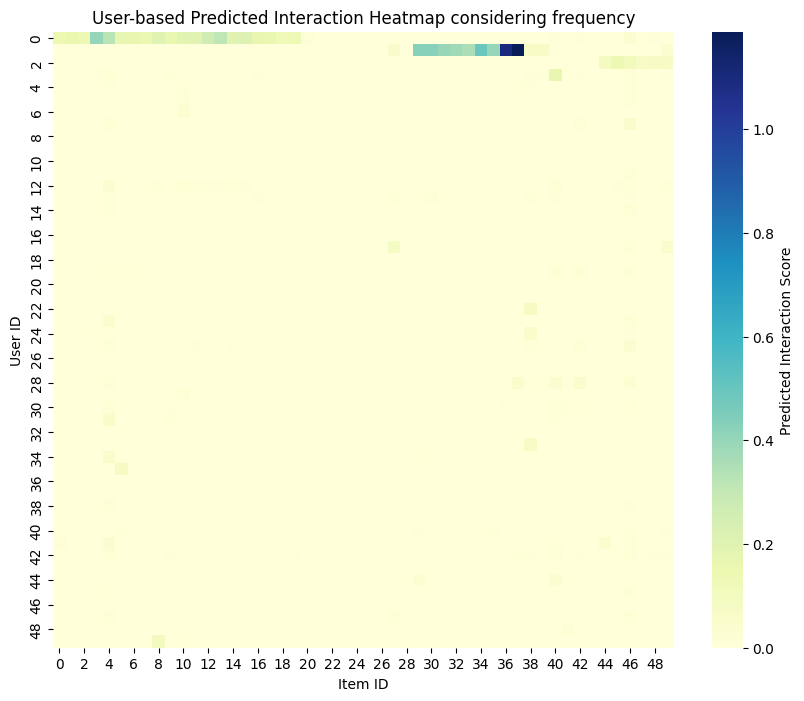

In [37]:
plot_interaction_prediction_heatmap(user_based_predictions2, title="User-based Predicted Interaction Heatmap considering frequency", num_users=50,num_items=50)

### Let's evaluate the model with these matrices

In [38]:
precision_user_k2, recall_user_k2,map_user_k2 = precision_recall_at_k(user_based_predictions2, test_data_matrix, k=10)
print('User-based CF Precision@K for k=10:', precision_user_k2)
print('User-based CF Recall@K for k=10:', recall_user_k2)
print('User-based CF MAP@K for k=10:', map_user_k2)

User-based CF Precision@K for k=10: 0.05734881347282771
User-based CF Recall@K for k=10: 0.28919170638362024
User-based CF MAP@K for k=10: 0.017430932737133406


### Dataframe with improved recommendations

In [39]:
recommendations_df2 = create_recommendations_csv(user_based_predictions2, name='user_based_recommendations2.csv')
recommendations_df2.head()

Recommendations CSV created successfully.


,user_id,recommendation
0,0,3 4 13 12 15 11 14 8 10 5
1,1,37 36 34 29 30 31 35 32 33 5219
2,2,53 58 14578 3055 81 13912 8999 13587 7124 76
3,3,132 10475 118 117 146 149 10476 128 40 152
4,4,202 198 203 191 193 201 197 199 195 196


### Recommendations for a specific user

In [40]:
import random
# Pick a user at random
user_id = random.choice(range(user_based_predictions2.shape[0]))
print("Selected User ID:", user_id)

# Get top-10 recommendations for the selected user
top_10 = np.argsort(user_based_predictions2[user_id, :])[-10:][::-1]

display(top_10)

Selected User ID: 3811


array([13166, 10260,  2820,  9360,  6572, 13574,  1535,   404,  1532,
        4094])

In [41]:
top_10_df = pd.DataFrame({'i':top_10})

In [42]:
df = top_10_df.merge(items_df[['i', 'Title', 'ISBN Valid']], left_on='i', right_on='i')
display(df)

,i,Title,ISBN Valid
0,13166,Embryologie médicale /,9782361100797; 2361100797
1,10260,L'infirmier(e) en psychiatrie : les grands pri...,9782294086212; 229408621X
2,2820,Soins infirmiers : médecine et chirurgie /,9782804165567; 2804165566; 9782804165574; 2804...
3,9360,Drôle d'histoire ces métiers : renifleur de ca...,9782940673780; 2940673780
4,6572,MKSAP 19 : medical knowledge self-assessment p...,9781938245756; 193824575X; 9781938245787; 1938...
5,13574,Psychiatrie /,9782294770562; 2294770560
6,1535,Psychiatrie et santé mentale /,9782766153329; 2766153322
7,404,Soins infirmiers en périnatalité /,9782761392969; 2761392965
8,1532,Evaluation clinique d'une personne symptomatiq...,9782766149421; 2766149422
9,4094,La liberté d'être ou la voie de la plénitude /,2980630160; 9782980630163


## Improving similarity with book information

In [47]:
items_df.isna().sum()

Title            0
Author        1181
ISBN Valid     723
Publisher       23
Subjects      1709
i                0
dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create one column with all the text data
#items_df['content'] = items_df['Title'].fillna('') + ' ' + items_df['Subjects'].fillna('') + ' ' + items_df['Author'].fillna('')
#items_df['content'] = items_df['Title'].fillna('') + ' ' + items_df['Subjects'].fillna('') + ' ' + items_df['Author'].fillna('') + ' ' + items_df['Publisher'].fillna('')
#items_df['content'] = items_df['Title'].fillna('') + ' ' + items_df['Author'].fillna('') + ' ' + items_df['Publisher'].fillna('')
items_df['content'] = items_df['Subjects'].fillna('') + ' ' + items_df['Author'].fillna('') + ' ' + items_df['Publisher'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf.fit_transform(items_df['content'])

print(tfidf_matrix.shape)

(15291, 37575)


In [49]:
content_similarity = cosine_similarity(tfidf_matrix)
print(content_similarity)
print(content_similarity.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.01781152]
 ...
 [0.         0.         0.         ... 1.         0.07387892 0.        ]
 [0.         0.         0.         ... 0.07387892 1.         0.        ]
 [0.         0.         0.01781152 ... 0.         0.         1.        ]]
(15291, 15291)


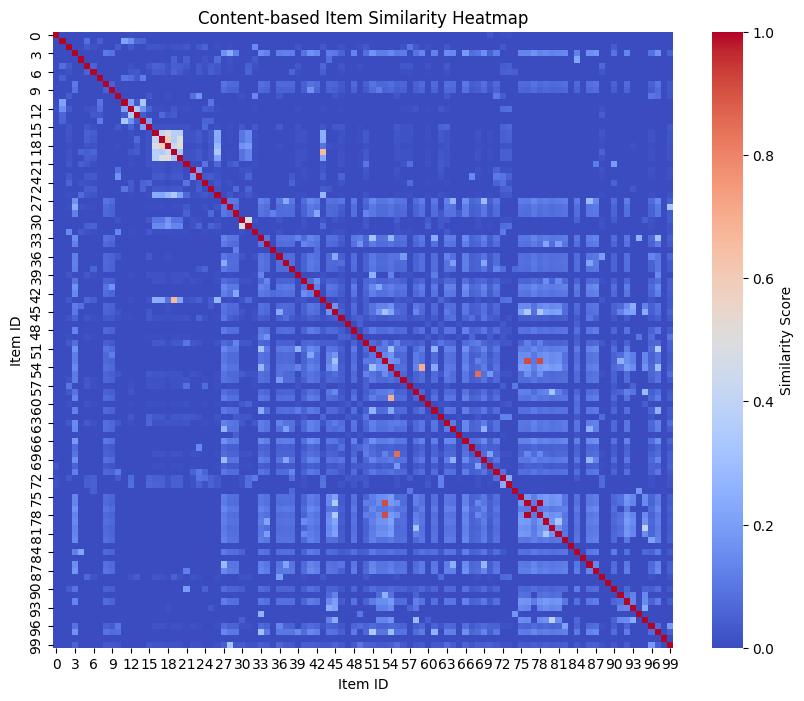

In [50]:
plot_similarity_heatmap(content_similarity, n_items=100, title="Content-based Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

In [51]:
items_df[(items_df['i']==53) | (items_df['i']==78)]

,Title,Author,ISBN Valid,Publisher,Subjects,i,content
53,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351420171; 2351420179; 9782351420188; 2351...,Kurokawa,Shônen; Mangas; Bandes dessinées,53,"Shônen; Mangas; Bandes dessinées Arakawa, Hiro..."
78,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351427552; 2351427556; 9782351427521; 2351...,Kurokawa,Bandes dessinées; Mangas,78,"Bandes dessinées; Mangas Arakawa, Hiromu, 1973..."


In [52]:
content_similarity[53, 78]

0.9118873593465162

In [53]:
content_based_predictions = item_based_predict(train_data_matrix, content_similarity)
print("Predicted Interaction Matrix using Content-based Similarity")
print(content_based_predictions)

Predicted Interaction Matrix using Content-based Similarity
[[2.91811464e-02 1.39663806e-02 7.40384790e-03 ... 0.00000000e+00
  2.14735456e-03 8.30067090e-04]
 [0.00000000e+00 0.00000000e+00 9.01635817e-04 ... 0.00000000e+00
  3.49721113e-03 5.76571021e-05]
 [1.33307850e-03 0.00000000e+00 1.69675214e-03 ... 3.07434664e-02
  3.65372829e-02 1.09940786e-03]
 ...
 [0.00000000e+00 0.00000000e+00 5.85421429e-05 ... 1.74918143e-03
  6.54004840e-04 4.62765957e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.95148616e-03
  1.28554371e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.46545487e-04 6.46449670e-04]]


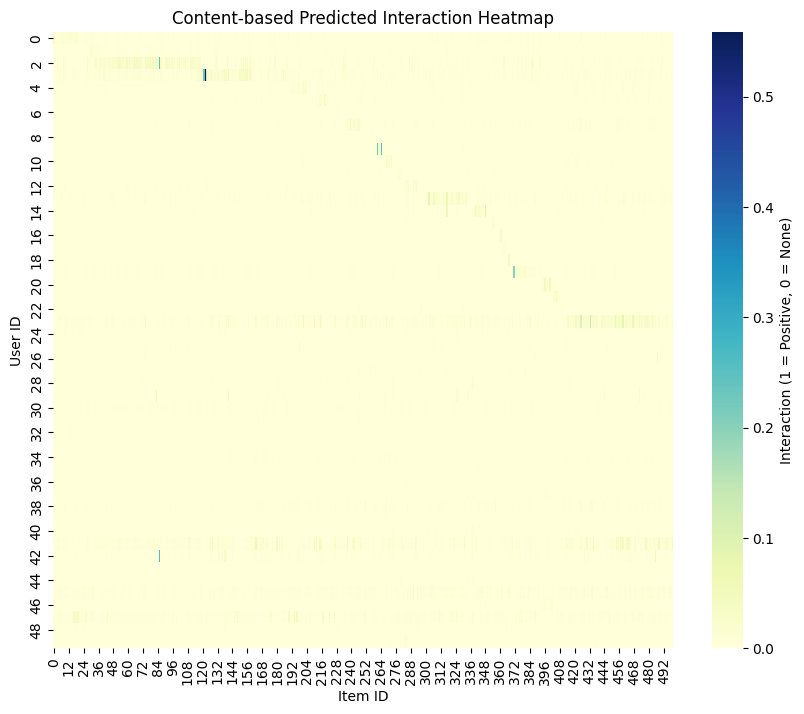

In [54]:
plot_interaction_heatmap1(content_based_predictions, n_users=50, n_items=500, title="Content-based Predicted Interaction Heatmap")

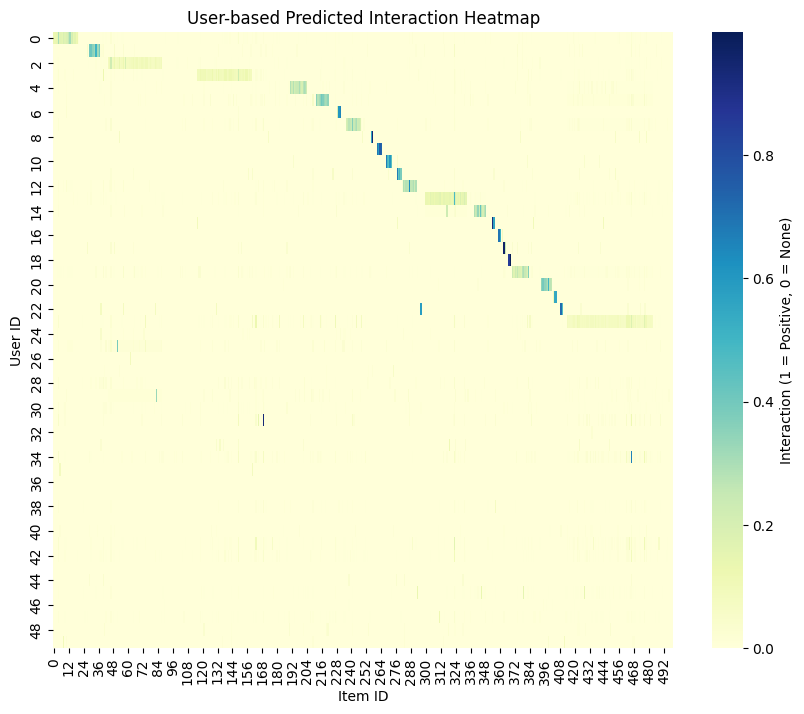

In [55]:
plot_interaction_heatmap1(user_based_predictions, n_users=50, n_items=500, title="User-based Predicted Interaction Heatmap")

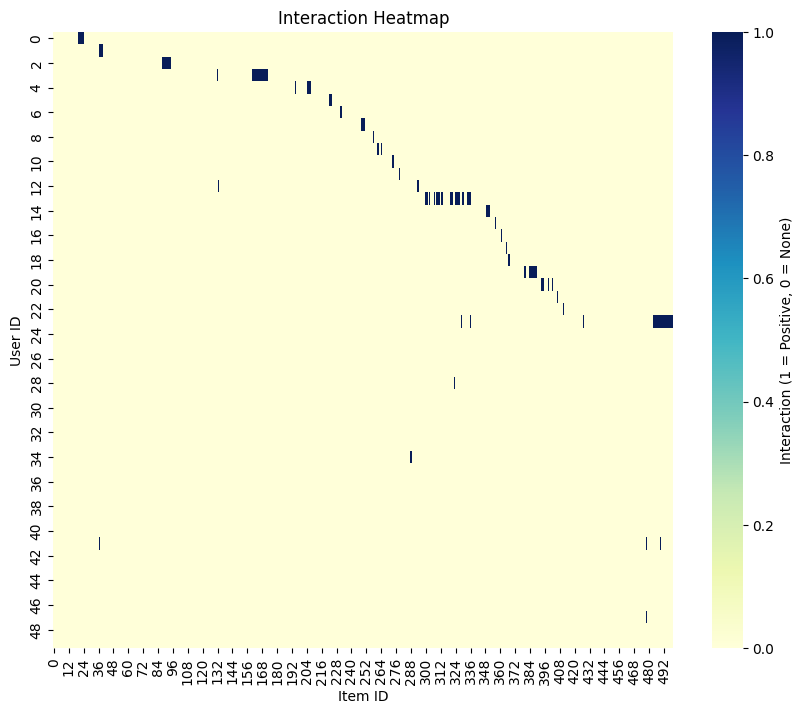

In [56]:
plot_interaction_heatmap1(test_data_matrix,50,500)

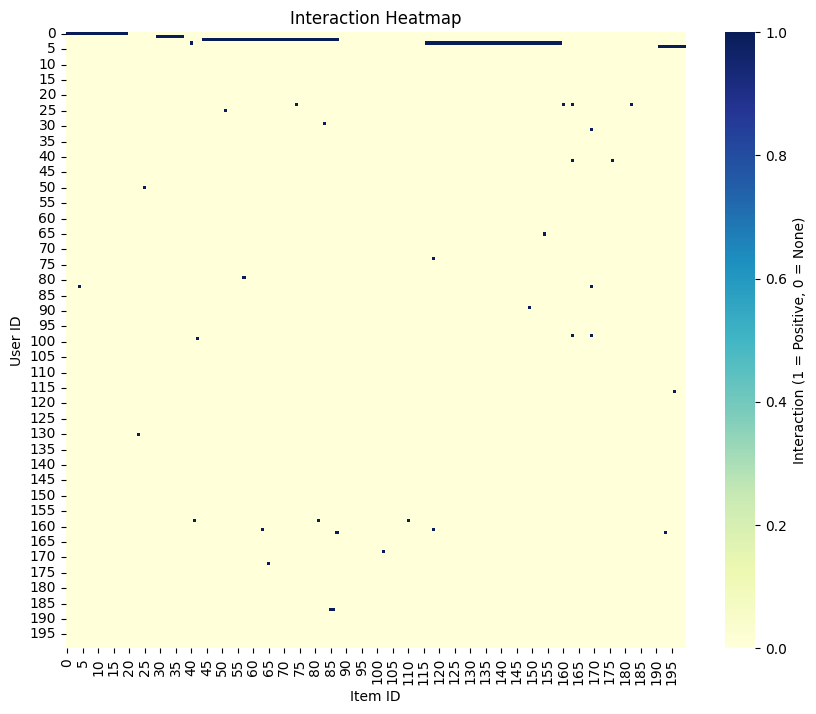

In [57]:
plot_interaction_heatmap1(train_data_matrix,200,200)


In [58]:
precision_content_k, recall_content_k, map_content_k = precision_recall_at_k(content_based_predictions, test_data_matrix, k=10)
print('Content-based CF Precision@K for k=10:', precision_content_k)   
print('Content-based CF Recall@K for k=10:', recall_content_k)
print('Content-based CF MAP@K for k=10:', map_content_k)

Content-based CF Precision@K for k=10: 0.033095177341157536
Content-based CF Recall@K for k=10: 0.18834625708369765
Content-based CF MAP@K for k=10: 0.009089443168608826


## Hybrid: item & user similarities combined

In [59]:
ground_truth_df = test_data.groupby('user_id')['i'].apply(list).reset_index()
ground_truth_df.rename(columns={'i': 'actual_books_viewed'}, inplace=True)
ground_truth_df

,user_id,actual_books_viewed
0,0,"[20, 21, 22, 23, 24]"
1,1,"[37, 38, 38, 39]"
2,2,"[88, 89, 90, 91, 91, 91, 91, 92, 92, 92, 93, 9..."
3,3,"[160, 161, 161, 162, 163, 164, 165, 166, 167, ..."
4,4,"[205, 206, 207, 195]"
...,...,...
7833,7833,[7760]
7834,7834,"[1367, 1367]"
7835,7835,[6791]
7836,7836,[3471]


In [60]:
hybrid_predictions = user_based_predictions2*0.5 + content_based_predictions*0.5
print(precision_recall_at_k(hybrid_predictions, test_data_matrix, k=10))

(0.05769328910436639, 0.2920716063634624, 0.017446536409920017)


In [61]:
hybrid_predictions2 = user_based_predictions2*0.3 + content_based_predictions*0.7
print(precision_recall_at_k(hybrid_predictions2, test_data_matrix, k=10))

(0.057808114314879325, 0.2934524550581104, 0.017480705516875562)


In [62]:
hybrid_recommendations_df = create_recommendations_csv(hybrid_predictions, name='hybrid_recommendation1.csv')

Recommendations CSV created successfully.


In [63]:
hybrid_recommendations_df2 = create_recommendations_csv(hybrid_predictions2, name='hybrid_recommendation2.csv')

Recommendations CSV created successfully.


In [64]:
hybrid_predictions3 = user_based_predictions*0.5 + item_based_predictions*0.5 
print(precision_recall_at_k(hybrid_predictions2, test_data_matrix, k=10))

(0.057808114314879325, 0.2934524550581104, 0.017480705516875562)


In [65]:
hybrid_predictions4 = user_based_predictions*0.7 + item_based_predictions*0.3
print(precision_recall_at_k(hybrid_predictions2, test_data_matrix, k=10))

(0.057808114314879325, 0.2934524550581104, 0.017480705516875562)


In [66]:
hybrid_recommendations_df3 = create_recommendations_csv(hybrid_predictions3, name='hybrid_recommendation3.csv')

Recommendations CSV created successfully.


In [67]:
hybrid_recommendations_df4 = create_recommendations_csv(hybrid_predictions4, name='hybrid_recommendation4.csv')

Recommendations CSV created successfully.


In [71]:
hybrid_predictions5 = user_based_predictions2*0.7 + item_based_predictions*0.3
print(precision_recall_at_k(hybrid_predictions5, test_data_matrix, k=10))

(0.05865016585864055, 0.2926113969983777, 0.01757353268772008)


In [72]:
hybrid_recommendations_df5 = create_recommendations_csv(hybrid_predictions5, name='hybrid_recommendation5.csv')

Recommendations CSV created successfully.


In [73]:
hybrid_predictions6 = user_based_predictions2*0.5 + item_based_predictions*0.25 + content_based_predictions*0.25
print(precision_recall_at_k(hybrid_predictions6, test_data_matrix, k=10))

(0.05880326613932445, 0.2941932322372524, 0.017488320028190025)


In [74]:
hybrid_recommendations_df6 = create_recommendations_csv(hybrid_predictions6, name='hybrid_recommendation6.csv')

Recommendations CSV created successfully.


## APIs

In [68]:
#version using Google Books and Open Library as fallback
'''import requests
import time
import pandas as pd
from tqdm.notebook import tqdm

# Copy original items table
items_improved = items_df.copy()

# --- UTILITY FUNCTIONS ---

# Extract first valid ISBN from a semicolon-separated field
def extract_first_isbn(isbn_field):
    if pd.isna(isbn_field):
        return None
    isbn_list = str(isbn_field).split(';')
    if len(isbn_list) > 0:
        isbn = ''.join(c for c in isbn_list[0].strip() if c.isdigit())
        return isbn
    return None

# Fetch metadata from Google Books API
def fetch_book_metadata_google(isbn):
    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            items = data.get("items", [])
            if items:
                info = items[0].get("volumeInfo", {})
                author = info.get("authors", [None])[0]
                publisher = info.get("publisher")
                subject = info.get("categories", [None])[0]
                return author, publisher, subject
    except Exception as e:
        print(f"Google Books error for ISBN {isbn}: {e}")
    return None, None, None

# Fetch metadata from Open Library API
def fetch_book_metadata_openlibrary(isbn):
    url = f"https://openlibrary.org/isbn/{isbn}.json"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            author = None
            if "authors" in data and data["authors"]:
                author_key = data["authors"][0]["key"]
                auth_response = requests.get(f"https://openlibrary.org{author_key}.json")
                if auth_response.status_code == 200:
                    author = auth_response.json().get("name")
            publisher = data.get("publishers", [None])[0]
            subject = data.get("subjects", [None])[0] if data.get("subjects") else None
            return author, publisher, subject
    except Exception as e:
        print(f"Open Library error for ISBN {isbn}: {e}")
    return None, None, None

# --- ENRICHMENT PROCESS ---

# Identify rows with missing Author or Subjects and valid ISBN
missing_data = items_improved[
    (items_improved['Author'].isna() | items_improved['Subjects'].isna()) &
    (~items_improved['ISBN Valid'].isna())
]

print(f"\nBooks needing metadata: {len(missing_data)}")

successful_fetches = 0

for idx in tqdm(missing_data.index):
    isbn = extract_first_isbn(items_improved.at[idx, 'ISBN Valid'])
    if not isbn:
        continue

    need_author = pd.isna(items_improved.at[idx, 'Author'])
    need_subject = pd.isna(items_improved.at[idx, 'Subjects'])
    need_publisher = pd.isna(items_improved.at[idx, 'Publisher'])

    # First try Google Books
    author, publisher, subject = fetch_book_metadata_google(isbn)

    # If not found, try Open Library
    if not author and not subject and not publisher:
        author, publisher, subject = fetch_book_metadata_openlibrary(isbn)

    if author and need_author:
        items_improved.at[idx, 'Author'] = author
        successful_fetches += 1

    if subject and need_subject:
        items_improved.at[idx, 'Subjects'] = subject
        successful_fetches += 1

    if publisher and need_publisher:
        items_improved.at[idx, 'Publisher'] = publisher

    time.sleep(0.1)  # Respect API rate limits

# Final fallback for truly missing values
#items_improved['Author'].fillna("Unknown Author", inplace=True)
#items_improved['Subjects'].fillna("Uncategorized", inplace=True)
#items_improved['Publisher'].fillna("Unknown Publisher", inplace=True)
#items_improved['ISBN Valid'].fillna("Not Available", inplace=True)

# Print results
print(f"\nSuccessful metadata fetches: {successful_fetches}")
print("Remaining missing values:")
print(items_improved.isnull().sum())

# Merge back with interaction data
interactions_with_items_improved = interactions_train_df.merge(items_improved, on='i', how='left')
print("\nSample of enhanced data:")
print(interactions_with_items_improved.sample(5))'''

'import requests\nimport time\nimport pandas as pd\nfrom tqdm.notebook import tqdm\n\n# Copy original items table\nitems_improved = items_df.copy()\n\n# --- UTILITY FUNCTIONS ---\n\n# Extract first valid ISBN from a semicolon-separated field\ndef extract_first_isbn(isbn_field):\n    if pd.isna(isbn_field):\n        return None\n    isbn_list = str(isbn_field).split(\';\')\n    if len(isbn_list) > 0:\n        isbn = \'\'.join(c for c in isbn_list[0].strip() if c.isdigit())\n        return isbn\n    return None\n\n# Fetch metadata from Google Books API\ndef fetch_book_metadata_google(isbn):\n    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"\n    try:\n        response = requests.get(url)\n        if response.status_code == 200:\n            data = response.json()\n            items = data.get("items", [])\n            if items:\n                info = items[0].get("volumeInfo", {})\n                author = info.get("authors", [None])[0]\n                publisher = 

## Text embedding

In [107]:
items_df

,Title,Author,ISBN Valid,Publisher,Subjects,i,content
0,Classification décimale universelle : édition ...,['UDC Consortium (The Hague)'],9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,Classification décimale universelle; Indexatio...
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,didactique--langue étrangère - enseignement; d...
2,Histoire de vie et recherche biographique : pe...,"['Aneta Slowik', 'Hervé Breton', 'Gaston Pineau']",2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Histoires de vie en sociologie; Sciences socia...
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,Moyen-Orient; Bandes dessinées autobiographiqu...
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,France--1945-1975; Roman historique; Roman fra...
...,...,...,...,...,...,...,...
15286,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas,15286,"Mangas Fukutani, Takashi, 1952-2000 Le Lézard..."
15287,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,NaN,15287,"Park, Yong-Je Kbooks"
15288,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...,15288,Compétitions; Football; Entraînement (sports);...
15289,Red eyes sword : akame ga kill ! Zero /,Takahiro,9782368522134; 2368522131; 9782368522141; 2368...,Kurokawa,Bandes dessinées; Mangas,15289,Bandes dessinées; Mangas Takahiro Kurokawa


In [69]:
pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [75]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_text_embedding(text):
    # Tokenize the text and get the BERT token IDs
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # Get the embeddings from BERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # The embeddings of the [CLS] token are usually used to represent the entire sequence
    return outputs.last_hidden_state[:, 0, :].numpy()

# Example: Create embeddings for the first 5 books
embeddings = []
for content in items_df['content']:
    embeddings.append(get_text_embedding(content))

# Convert to a numpy array
embeddings = np.vstack(embeddings)

print(embeddings.shape)  
print(embeddings)

(15291, 768)
[[-0.73623574  0.06880704 -0.25109506 ... -0.14736727  0.46854708
   0.7636646 ]
 [-0.7354101   0.26398733 -0.5282884  ... -0.2699282   0.3345589
   0.71176255]
 [-0.8404676   0.14097944 -0.3431284  ... -0.10901543  0.15717518
   0.93031406]
 ...
 [-0.4758057  -0.42919803 -0.53611195 ...  0.01872033  0.5297469
   0.22514156]
 [-0.5868149  -0.13412784 -0.4395413  ...  0.01869656  0.6956583
   0.25711554]
 [-0.16588978  0.31424326 -0.12780704 ... -0.21797073  0.3406743
   0.5255889 ]]


In [76]:
embeddings_similarity = cosine_similarity(embeddings)
print(embeddings_similarity)

[[0.9999999  0.8747351  0.8381748  ... 0.81104445 0.8044585  0.855037  ]
 [0.8747351  0.99999994 0.8564098  ... 0.79024005 0.81882894 0.84641105]
 [0.8381748  0.8564098  1.         ... 0.772938   0.7857542  0.7671698 ]
 ...
 [0.81104445 0.79024005 0.772938   ... 1.         0.86557364 0.7637665 ]
 [0.8044585  0.81882894 0.7857542  ... 0.86557364 1.0000001  0.7689674 ]
 [0.855037   0.84641105 0.7671698  ... 0.7637665  0.7689674  0.99999976]]


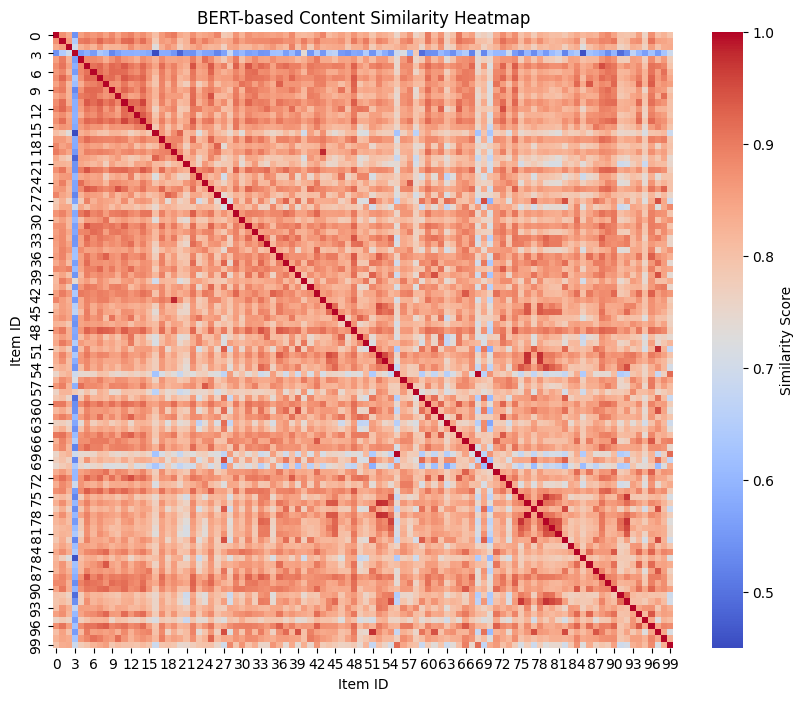

In [77]:
plot_similarity_heatmap(embeddings_similarity, n_items=100, title="BERT-based Content Similarity Heatmap",x_label='Item ID',y_label='Item ID')

In [80]:
embeddings_content_based_predictions = item_based_predict(train_data_matrix, embeddings_similarity)
print("Predicted Interaction Matrix using BERT-based Content Similarity")
print(embeddings_content_based_predictions)

Predicted Interaction Matrix using BERT-based Content Similarity
[[0.00133738 0.00133567 0.0013286  ... 0.00131895 0.00131197 0.00133378]
 [0.00060006 0.0006037  0.00059464 ... 0.00061179 0.00061518 0.00060215]
 [0.00282193 0.00285712 0.00284403 ... 0.0029356  0.00300978 0.00282865]
 ...
 [0.00012476 0.00012202 0.00012174 ... 0.00013159 0.00013026 0.00012721]
 [0.00012856 0.00013001 0.00012865 ... 0.00012871 0.00013412 0.0001324 ]
 [0.00012894 0.0001294  0.00012749 ... 0.00013379 0.00014413 0.0001333 ]]


In [81]:
print(precision_recall_at_k(embeddings_content_based_predictions, test_data_matrix, k=10))

(0.019175810155651455, 0.13371180721372808, 0.0037109958808734917)


### Text embedding 2

In [85]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [109]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Example: Assuming 'items_df' contains metadata like 'title' or 'description' of items (books)
# Get embeddings for book descriptions or titles (you can choose whichever you prefer)
item_descriptions = items_df['content'].tolist()

# Generate embeddings for the items
item_embeddings = model.encode(item_descriptions, show_progress_bar=True)

# Check the shape of the embeddings (should be num_items x embedding_dim, e.g., (10000, 384))
print(item_embeddings.shape)


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

(15291, 384)


In [110]:
embeddings_similarity = cosine_similarity(item_embeddings)

In [106]:
embeddings_similarity.shape

(15291, 15291)

In [112]:
item_similarity.shape

(15291, 15291)

In [125]:
hybrid_similarity = item_similarity*0.75 + embeddings_similarity*0.25

In [126]:
hybrid_predictions_embedding = item_based_predict(train_data_matrix,hybrid_similarity)
#print("Predicted Interaction Matrix using Sentence-BERT-based Content Similarity")
#print(embeddings_content_based_predictions)
print(precision_recall_at_k(hybrid_predictions_embedding, test_data_matrix, k=10))

(0.05687675427405247, 0.28608620302040466, 0.016562493671450237)


In [120]:
hybrid_predictions_embedding = item_based_predict(train_data_matrix,hybrid_similarity)
#print("Predicted Interaction Matrix using Sentence-BERT-based Content Similarity")
#print(embeddings_content_based_predictions)
print(precision_recall_at_k(hybrid_predictions_embedding, test_data_matrix, k=10))

(0.05697882112784166, 0.2854863654663948, 0.016471484060154834)


In [116]:
hybrid_predictions_embedding = item_based_predict(train_data_matrix,hybrid_similarity)
#print("Predicted Interaction Matrix using Sentence-BERT-based Content Similarity")
#print(embeddings_content_based_predictions)
print(precision_recall_at_k(hybrid_predictions_embedding, test_data_matrix, k=10))

(0.05664710385302671, 0.28583693282455325, 0.016544206693479648)


In [111]:
embeddings_content_based_predictions = item_based_predict(train_data_matrix, embeddings_similarity)
#print("Predicted Interaction Matrix using Sentence-BERT-based Content Similarity")
#print(embeddings_content_based_predictions)
print(precision_recall_at_k(embeddings_content_based_predictions, test_data_matrix, k=10))

(0.01935442714978261, 0.13072690421377547, 0.005484893498098435)


## NCF

In [127]:
pip install recommenders

python(18635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [129]:
pip install tensorflow

python(18743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 2.8 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 3.6 MB/s eta 0:00:0000:0100:01
Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl (20.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.1/629.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3

In [131]:
pip install tf_slim

python(18812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [132]:
pip install logging

python(18821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 14, in <module>
        File "/Users/nadegelan/MGT-502/.conda/lib/python3.11/site-packages/setuptools/__init__.py", line 22, in <module>
          import _distutils_hack.override  # noqa: F401
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/nadegelan/MGT-502/.conda/lib/python3.11/site-packages/_distutils_hack/override.py", line 1, in <module>
          __import__('_distutils_hack').do_override()
        File "/Users/nadegelan/MGT-502/.conda/lib/python3.11/site-packages/_distutils_hack/__init__.py", line 89, in do_override
          ensure_local_distutils()
        File "/Users/nadegelan/MGT-502/.conda/lib/python3.11/site-packages/_distutils_hack/__init__.py", line

In [133]:
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.constants import SEED as DEFAULT_SEED

# Initial parameters
TOP_K = 10
EPOCHS = 50
BATCH_SIZE = 1024
SEED = DEFAULT_SEED


data = NCFDataset(train = train_data_matrix, test = test_data_matrix, seed=SEED)

model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=1,
    seed=SEED
)

# fitting the model
model.fit(data)

# predict the data in the test set
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test_data_matrix.iterrows()]

TypeError: Dataset.__init__() got an unexpected keyword argument 'train'